<a href="https://colab.research.google.com/github/MLcmore2023/MLcmore2023/blob/main/day9_am_morning/D9_Morning_REINFORCE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Absolutely! The REINFORCE algorithm is a type of policy gradient method used in reinforcement learning. Let's break down its principles first, and then implement it in PyTorch and Google Colab for the CartPole environment.

---

### REINFORCE Algorithm:

The main idea behind policy gradient methods is to directly optimize the policy function $\pi_\theta(a|s)$ which specifies the action `a` to take in state `s`, parameterized by $\theta$.

In REINFORCE, we're trying to maximize the expected return by directly adjusting the parameters $\theta$ of our policy.

The objective function is:
$ J(\theta) = \mathbb{E}_{\pi_\theta} [R(t)] $
Where $R(t)$ is the return from time `t`.

The gradient of this function is:
$ \nabla_\theta J(\theta) = \mathbb{E}_{\pi_\theta} [\nabla_\theta \log \pi_\theta(a|s) \times R(t)] $

This can be estimated using the following:
$ \nabla_\theta J(\theta) \approx \frac{1}{N} \sum_{i=1}^N \nabla_\theta \log \pi_\theta(a_i|s_i) \times R(t_i) $

Where $N$ is the number of episodes, and $(s_i, a_i)$ are the state-action pairs of episode `i`.

Pseudo code for the REINFORCE algorithm:

```
Initialize policy parameters θ
For each episode:
    Generate an episode S0, A0, R1, ..., ST-1, AT-1, RT following πθ
    For t=0 to T-1:
        G = sum from k=t+1 to T of γ^(k-t-1) * Rk
        θ = θ + α * γ^t * ∇_θ log πθ(At|St) * G
```
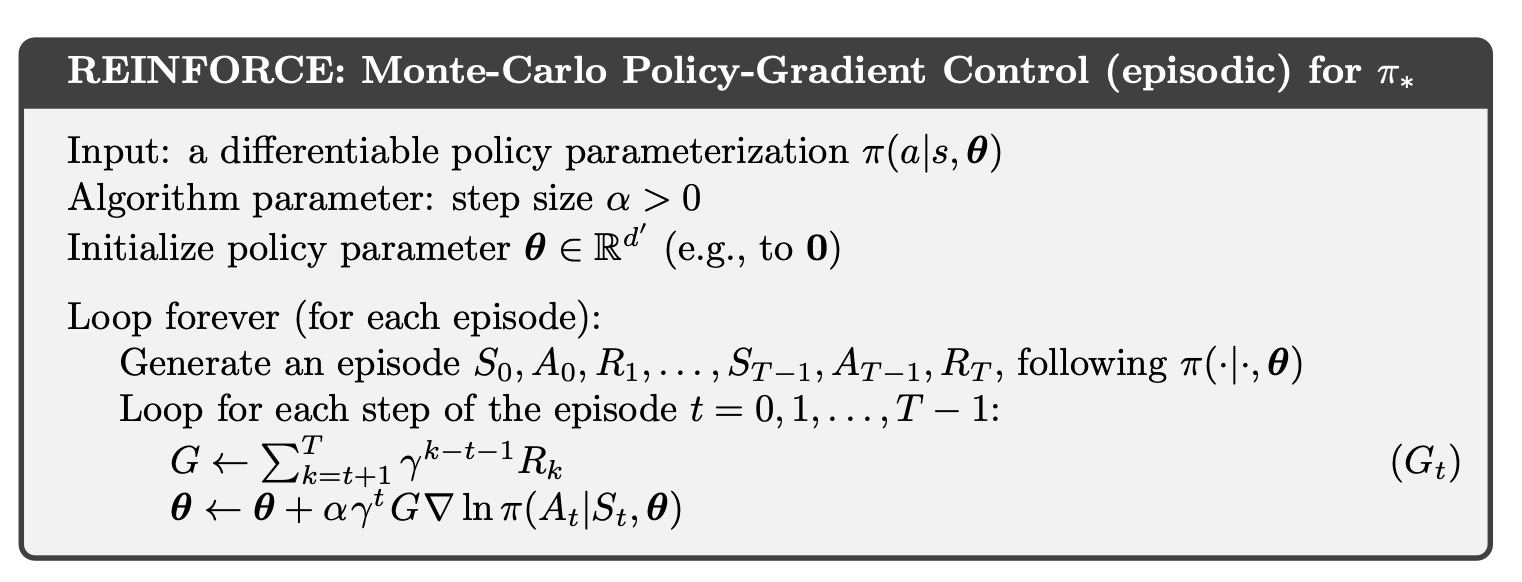


---

### Implementation in PyTorch:

We'll use the CartPole environment from the `gym` library as our environment. Here's how to do it:

1. **Setting up the Environment**

Let's start with the necessary imports and initial setup:

In [ ]:
%matplotlib inline

import gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import matplotlib
import matplotlib.pyplot as plt

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

env = gym.make("CartPole-v1")



2. **Define the Policy Network**

Our policy network will be a simple feed-forward neural network.

In [ ]:
class PolicyNetwork(nn.Module):
    def __init__(self,input_dim,
                 output_dim,
                 hidden_dims=(32,32),
                 activation_fc=F.relu):
        super(PolicyNetwork, self).__init__()
        self.activation_fc = activation_fc

        self.input_layer = nn.Linear(input_dim, hidden_dims[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            hidden_layer = nn.Linear(hidden_dims[i], hidden_dims[i+1])
            self.hidden_layers.append(hidden_layer)
        self.output_layer = nn.Linear(hidden_dims[-1], output_dim)
    def _format(self, state):
        x = state
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x,
                             dtype=torch.float32)
            x = x.unsqueeze(0)
        return x
    def forward(self, state):
        x = self._format(state)
        x = self.activation_fc(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation_fc(hidden_layer(x))
        return self.output_layer(x)

3. **Real-time Plotting Function**

This function will allow for the durations to be plotted in real-time:

In [ ]:
def plot_durations(episode_durations, show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

4. **REINFORCE Algorithm Function**

In [ ]:
def reinforce(env, policy, optimizer, num_episodes, gamma=0.99):
    episode_durations = []

    for episode in range(num_episodes):
        saved_log_probs = []
        rewards = []

        state = env.reset()
        t = 0
        done = False
        while not done:
            t += 1
            state_tensor = torch.FloatTensor([state]) # Convert state array to tensor
            logits = policy(state_tensor)  # Call the policy network given the state
            dist = torch.distributions.Categorical(logits=logits) # Convert the output of neural network (logits) to categorical distribution
            action = dist.sample() # Sample the policy distribution
            saved_log_probs.append(dist.log_prob(action).unsqueeze(-1)) # Logarithm of pi(a|s)

            state, reward, done, _ = env.step(action.item()) # Take that action into the env
            rewards.append(reward)

        episode_durations.append(t)

        R = 0
        policy_loss = []
        returns = []
        # Make the rewards discounted
        for r in rewards[::-1]:
            R = r + gamma * R
            returns.insert(0, R)

        returns = torch.tensor(returns) # Convert the dicounted rewards into tensor
        returns = (returns - returns.mean()) / (returns.std() + 1e-9)  # Normalize the returns

        # Calculating the loss function (dicounted_returns x log_prob)d
        for log_prob, R in zip(saved_log_probs, returns):
            policy_loss.append(-log_prob * R)

        optimizer.zero_grad()
        policy_loss = torch.cat(policy_loss).sum()
        policy_loss.backward() # Backpropagation step
        optimizer.step() # Updating the policy network weights

        plot_durations(episode_durations)

    return episode_durations

5. **Training the Policy**

In [ ]:
input_size = env.observation_space.shape[0] # the size of state space e.g., in cartpole is 4
output_size = env.action_space.n # size of action_space is 2 (Left, Right)

policy = PolicyNetwork(input_size, output_size, hidden_dims=(128,128))
optimizer = optim.Adam(policy.parameters(), lr=1e-4)

num_episodes = 800
episode_durations = reinforce(env, policy, optimizer, num_episodes)

print("Complete")
plot_durations(episode_durations, show_result=True)
plt.ioff()
plt.show()

In [ ]:
# Visualize the Policy
frames = []
for _ in range(5):
    state = env.reset()
    for t in range(100):
        logits = policy(state)
        dist = torch.distributions.Categorical(logits=logits)
        action = dist.sample()
        state, _, done, _ = env.step(action.item())
        frames.append(env.render(mode='rgb_array'))
        if done:
            break
env.close()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np
from IPython.display import HTML

plt.figure(figsize=(frames[0].shape[1]/72.0, frames[0].shape[0]/72.0), dpi = 72)
patch = plt.imshow(frames[0])
plt.axis('off')
animate = lambda i: patch.set_data(frames[i])
ani = matplotlib.animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval = 50)
HTML(ani.to_jshtml())

### Exercise:

Implement RINFORCE algorithm with baseline. Implement value network as the baseline

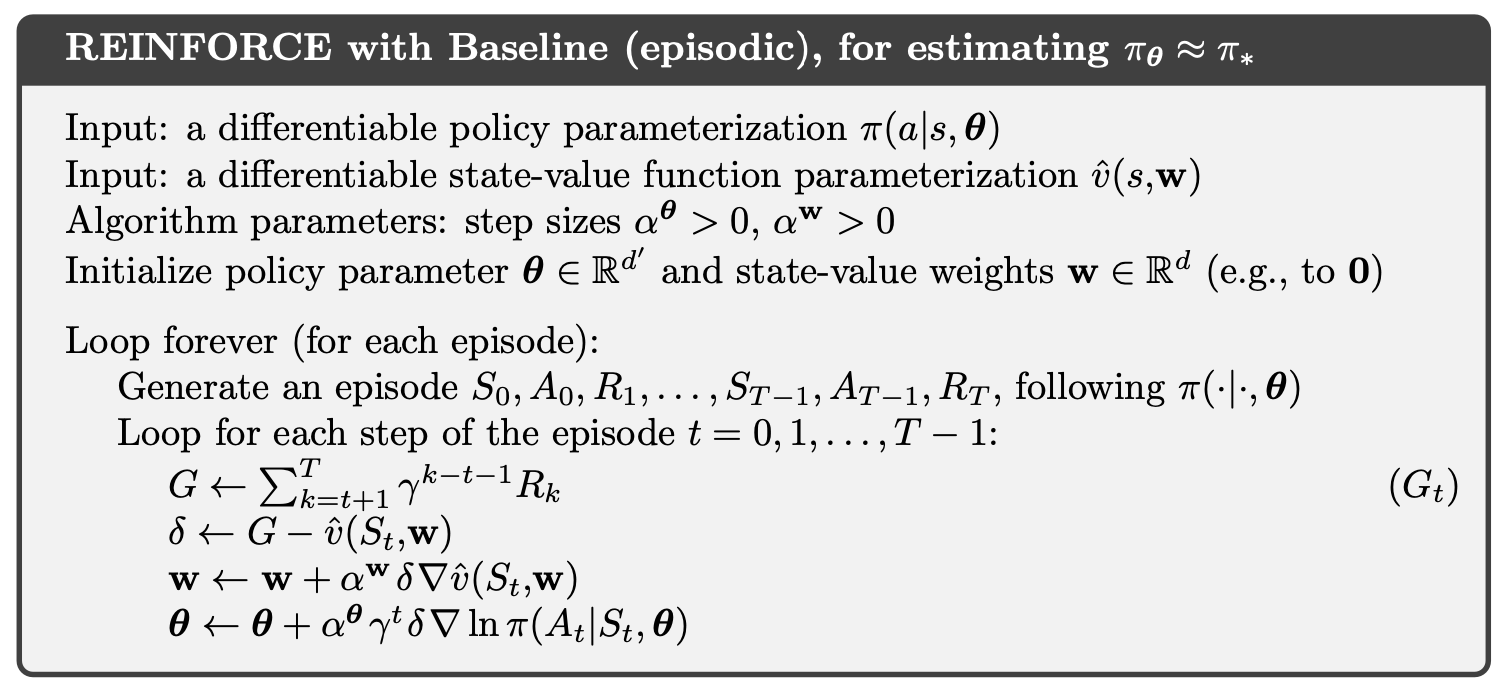

In [ ]:
plt.ion()

# Define Value Network
class ValueNetwork(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(ValueNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)

        # Complete

    def forward(self, x):
        y = self.fc1(x) # y = wx + b
        output_l1 = torch.tanh(y) # tanh(wx + b)
        y_l2 = self.fc2(output_l1) # y = wx = b
        output_l2 = torch.relu(y) # relu(wx + b)
        output = self.fc3(output_l2) # w(relu(wx+b)) + b
        return output
        # Complete

# REINFORCE with baseline
def reinforce_with_baseline(env, policy, value_network, policy_optimizer, value_optimizer, num_episodes, gamma=0.99):
    episode_durations = []

    for episode in range(num_episodes):
        saved_log_probs = []
        rewards = []
        states = []

        state = env.reset()
        done = False
        while not done:
            states.append(state)
            state_tensor = torch.FloatTensor([state])
            logits = policy(state_tensor)
            m = torch.distributions.Categorical(logits=logits)
            action = m.sample()
            saved_log_probs.append(m.log_prob(action))

            state, reward, done, _ = env.step(action.item())
            rewards.append(reward)

        episode_durations.append(len(rewards))

        returns = []
        R = 0
        for r in reversed(rewards):
            R = r + gamma * R
            returns.insert(0, R)
        returns = torch.tensor(returns)

        # Update value network

        value_optimizer.zero_grad()
        states_tensor = torch.FloatTensor(states)
        value_estimates = value_network(states_tensor).squeeze()
        value_loss = F.mse_loss(value_estimates, returns)
        value_loss.backward()
        value_optimizer.step()

        # Get the baseline (value estimates) for the states

        baselines = value_network(states_tensor).detach().squeeze()

        # REINFORCE update with baseline
        policy_loss = []
        for log_prob, R, baseline in zip(saved_log_probs, returns, baselines):

            policy_loss.append(-log_prob * (R - baseline))

        policy_optimizer.zero_grad()
        policy_loss = torch.stack(policy_loss).sum()
        policy_loss.backward()
        policy_optimizer.step()

        plot_durations(episode_durations)

    return episode_durations

# Train
env = gym.make('CartPole-v1')
input_size = env.observation_space.shape[0]
hidden_size = 128
output_size = env.action_space.n
policy = PolicyNetwork(input_size, output_size, hidden_dims=(128,128, 128))
value_network = ValueNetwork(input_size, hidden_size)
policy_optimizer = optim.Adam(policy.parameters(), lr=1e-4)
value_optimizer = optim.Adam(value_network.parameters(), lr=1e-4)
num_episodes = 1000
episode_durations = reinforce_with_baseline(env, policy, value_network, policy_optimizer, value_optimizer, num_episodes)

print("Complete")
plot_durations(episode_durations, show_result=True)
plt.ioff()
plt.show()

In [ ]:
plt.ion()
policy = PolicyNetwork(input_size, output_size, hidden_dims=(32,32))
value_network = ValueNetwork(input_size, 64)
policy_optimizer = optim.Adam(policy.parameters(), lr=1e-3)
value_optimizer = optim.Adam(value_network.parameters(), lr=1e-3)
num_episodes = 1000
episode_durations = reinforce_with_baseline(env, policy, value_network, policy_optimizer, value_optimizer, num_episodes)

print("Complete")
plot_durations(episode_durations, show_result=True)
plt.ioff()
plt.show()